In [1844]:
import os
os.chdir("/Users/davidamat/Documents/Projects/deepsetstats")
# os.chdir("/Users/davidamat/Documents/Personal/deepsetstats")

from deepsetstats.utils import utils_tools
from deepsetstats.utils import constants as c
from deepsetstats.utils import videocapture as vc
from deepsetstats.court_detection import edge_detection
from deepsetstats.utils import utils_viz as uv
from deepsetstats.utils import utils_colors as ucol
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
import copy
import torch
import colorsys
import time
import scipy.spatial as sp
from skimage.color import rgb2hsv, hsv2rgb
from matplotlib.colors import hsv_to_rgb, rgb_to_hsv
from scipy.spatial import distance_matrix

In [42]:
import pandas as pd
pd.options.display.max_columns = None
pd.options.display.max_rows = 1000
pd.options.display.width=None

In [2]:
%matplotlib inline
from importlib import reload
np.set_printoptions(threshold=2000)

In [2021]:
from importlib import reload
def rel():
    global utils_tools
    global c
    global vc
    global edge_detection
    global ucol
    global uv
    
    utils_tools = reload(utils_tools)
    c = reload(c)
    vc = reload(vc)
    edge_detection = reload(edge_detection)
    ucol = reload(ucol)
    uv = reload(uv)

In [2022]:
# Constants
rel()

Vis = uv.Visualizer()
Colors = ucol.Colors()

# 1. Load Videos and Dictionary of vids

In [5]:
# Dictionary of vids
extension = ".mp4"
gs = ["wb", "rg", "ao", "us"]

#c.PATH_VIDS = "/Users/davidamat/Documents/BackUp/DeepSetStats"
d_path_vids = {vid: str(Path(c.PATH_VIDS) / (vid + extension)) for vid in gs }
VC = vc.VideoClass(d_path_vids["rg"])
d_vc = { grandslam: vc.VideoClass(d_path_vids[grandslam]) for grandslam in gs}

# 2. Load frames

In [6]:
l_frames = [29*25, 29*25, 29*25, 25*25]
# in Color
d_f = {
   grandslam: d_vc[grandslam].get_frame(frame_num) for grandslam, frame_num in zip(gs, l_frames)
}

# In Black and White
d_fg = {
   grandslam: d_vc[grandslam]._correct_color(d_f[grandslam], gray=True) for grandslam in gs
}

# 3. Court Detection

In [7]:
# Input frame
tourn = "ao"
frame = d_f[tourn].copy()
frameg = d_fg[tourn].copy()
vt = d_vc[tourn]

## 3.1 Court Type

In [8]:
%%time
# Court type
rgb_court, court_type = VC.detect_court(frame)
print(f"Court Type: {court_type}")
print(f"Court RGB Colors: {c.D_GRAD_LINES[court_type]}")

Court Type: GREENSET_AO
Court RGB Colors: {'COURT': array([108, 156, 196]), 'LINE_CLEAN': array([200, 228, 240]), 'LINE_DIRTY': array([125, 180, 224])}
CPU times: user 1.94 ms, sys: 731 µs, total: 2.67 ms
Wall time: 1.71 ms


## 3.2 White Filtering

In [650]:
tourn = "rg"

In [651]:
%%time
frameg = d_fg[tourn].copy()
frame = d_f[tourn].copy()

CPU times: user 981 µs, sys: 489 µs, total: 1.47 ms
Wall time: 617 µs


In [652]:
%%time
ED = edge_detection.EdgeDetect(th=20 if tourn == "rg" else 30)
mask_edges = ED.img2edges(frameg)

CPU times: user 71.3 ms, sys: 16.8 ms, total: 88 ms
Wall time: 86.4 ms


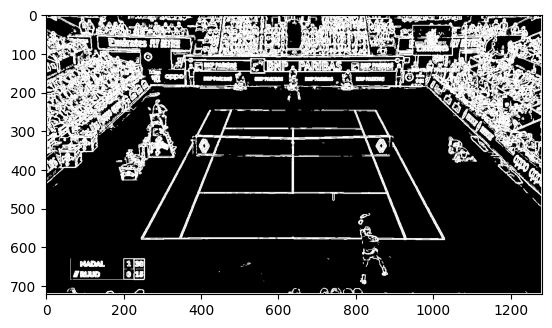

In [653]:
VC.show_gray(mask_edges)

In [654]:
%%time
frame_red, frame_green, frame_blue = frame.transpose(2,0,1)

CPU times: user 11 µs, sys: 1 µs, total: 12 µs
Wall time: 15.3 µs


In [655]:
np.median(frame_red)

178.0

In [656]:
np.median(frame_green)

97.0

In [657]:
np.median(frame_blue)

76.0

In [689]:
for tup_xy in d_xy_lines_v1[10]:
    y1, x1 = tup_xy 

In [696]:
y1, x1 = d_xy_lines_v1[10][8]

### Compare with the median color of the court

In [702]:
surr1 = frame[y1-10:y1-3,x1-10:x1-3, :]
surr2 = frame[y1-10:y1-3,x1+3:x1+10, :]
surr3 = frame[y1+3:y1+10,x1-10:x1-3, :]
surr4 = frame[y1+3:y1+10,x1+3:x1+10, :]

In [710]:
np.median(np.median(surr1, axis=1), axis=0)

array([188., 101.,  78.])

## Line Grid points

In [659]:
h,w,_ = frame.shape

In [660]:
%%time
#OPTION 1: Equispaced Nodes
x_slices = 17
y_slices = 17
marg_x = w // 20
marg_y = h // 20
x_vlines = np.linspace(marg_x, w - marg_x, x_slices, dtype=np.int16)
x_vlines_2 = np.linspace(marg_x // 2, w - marg_x - marg_x // 2, x_slices, dtype=np.int16)
y_hlines = np.linspace(marg_y, h - marg_y, y_slices, dtype=np.int16)
y_hlines_2 = np.linspace(marg_y // 2, h - marg_y - marg_y // 2, y_slices, dtype=np.int16)
y_diff = np.diff(y_hlines)[0]
x_diff = np.diff(x_vlines)[0]
# Ensure y_diff > linewidth !!!

CPU times: user 234 µs, sys: 38 µs, total: 272 µs
Wall time: 241 µs


### Final Line Detection Logic

In [661]:
def get_ones_line_mask(line):
    where_1s = np.where(line)[0]
    return where_1s

In [662]:
def get_ones_shift_diff(where_1s):
    # Get differences in indexes of 1s (consecutive indexes should be 0 diff, this is why -1)
    diff_position = np.ediff1d(where_1s) - 1
    
    # Mark with -1 the last position of the line
    diff_position = np.append(diff_position, -1)
    return diff_position

In [663]:
def get_idx_line_center(line):
    return int(np.ceil(np.mean(line)))

def get_line_width(line):
    return len(line)

In [664]:
def get_lines_from_mask(where_1s, diff_position):
    lines = []
    current_line = []
    len_line = len(line)
    for idx_where in range(len(diff_position)):
        pos_1 = where_1s[idx_where]
        diffpos_1 = diff_position[idx_where]

        if diffpos_1 == -1:
            # How many zeros are left
            if len_line - pos_1 - 1 >= 3:
                current_line.append(pos_1)
                if len(current_line) >= 2:
                    lines.append(current_line)
                current_line = []

        # Consider as the same line
        elif diffpos_1 <= 1:
            current_line.append(pos_1)
            
        # Split to a new line
        elif diffpos_1 >= 20:
            current_line.append(pos_1)
            if len(current_line) >= 2:
                lines.append(current_line)
            current_line = []
        else:
            if len(current_line) >= 2:
                current_line.append(pos_1)
                lines.append(current_line)
                current_line = []
            else:
                current_line = []
                
    # Filter only lines less than length 6
    lines = [line for line in lines if get_line_width(line) < 11]
    return lines

In [665]:
def get_coordinates_lines(edges, grid_lines, is_vertical = True):
    d_lines = {}
    d_xy_lines = {}
    # ------------------------------------- #
    #     Vertical shift
    # ------------------------------------- #
    for idx, pos_fix in enumerate(grid_lines):

        if is_vertical:
            # [VERTICAL SLICE] Get 0/1 of the line
            line = np.abs(edges[:,pos_fix:pos_fix+1] - 1).ravel()
        else:
            # [HORIZONTAL SLICE] Get 0/1 of the line
            line = np.abs(edges[pos_fix:pos_fix+1,:] - 1).ravel()

        # Find places where the line is max intensity pixel (1)
        where_1s = get_ones_line_mask(line)

        # Find the differences between the consecutive places of 1s
        diff_position = get_ones_shift_diff(where_1s)

        # Decide if those differences correspond to a line or an artifact
        lines = get_lines_from_mask(where_1s, diff_position)

        # Get the possible center of that line
        l_idx_line_center = [get_idx_line_center(line) for line in lines]
        l_len_line = [get_line_width(line) for line in lines]

        # Save results
        d_lines[idx] = lines
        if is_vertical:
            d_xy_lines[idx] = [(idx_var, pos_fix) for idx_var in l_idx_line_center]
        else:
            d_xy_lines[idx] = [(pos_fix, idx_var) for idx_var in l_idx_line_center]
    return d_xy_lines

In [1954]:
def putText(img, pos, text):
    #pos = (10,500)
    fontScale = 2
    fontColor = (0,0,0)
    thickness = 1
    lineType = 1

    cv2.putText(img, text, 
        pos, 
        cv2.FONT_HERSHEY_PLAIN, 
        fontScale,
        fontColor,
        thickness,
        lineType)
    return img

In [666]:
%%time
d_xy_lines_v1 = get_coordinates_lines(mask_edges, x_vlines, is_vertical=True)
d_xy_lines_h1 = get_coordinates_lines(mask_edges, y_hlines, is_vertical=False)
d_xy_lines_v2 = get_coordinates_lines(mask_edges, x_vlines_2, is_vertical=True)
d_xy_lines_h2 = get_coordinates_lines(mask_edges, y_hlines_2, is_vertical=False)

CPU times: user 21.8 ms, sys: 1.65 ms, total: 23.4 ms
Wall time: 21.9 ms


## Filter points that are in a line

In [2062]:
tourn = "ao"

In [2063]:
%%time
frameg = d_fg[tourn].copy()
frame = d_f[tourn].copy()

CPU times: user 1.46 ms, sys: 3.38 ms, total: 4.83 ms
Wall time: 3.91 ms


In [2064]:
%%time
frame_lab = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
frame_lab = np.array(frame_lab, dtype=int)

CPU times: user 6.98 ms, sys: 2.84 ms, total: 9.83 ms
Wall time: 6.34 ms


In [2065]:
%%time
top_rgb, top_hex, top_lab = Colors.run_top_colors_court(frame, top_k=4)

CPU times: user 80.4 ms, sys: 18.1 ms, total: 98.5 ms
Wall time: 98.2 ms


In [ ]:
show_l

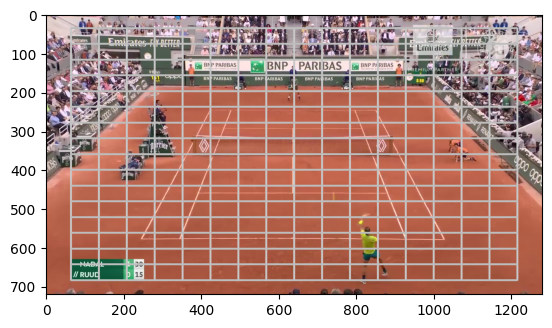

In [2024]:
# Visualize strategy
mask_edges_grid = frame.copy()
for xx in x_vlines:
    cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (200, 200, 200), 3)
    pass
for yy in y_hlines:
    cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (190, 190, 190), 3)
    pass
for xx in x_vlines_2:
    #cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
    pass
for yy in y_hlines_2:
    #cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
    pass
VC.show_frame(mask_edges_grid)

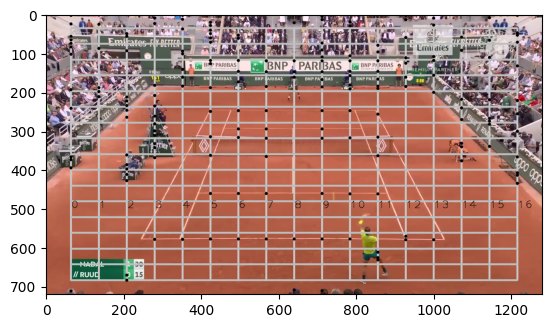

In [1961]:
plot_frame = mask_edges_grid.copy()
#for d_iter in [d_xy_lines_h1, d_xy_lines_v1, d_xy_lines_v2, d_xy_lines_h2]:
for d_iter in [d_xy_lines_v1]:
    for idx_line, l_tup_xy in d_iter.items():
        for tup_xy in l_tup_xy:
            y1, x1 = tup_xy
            cv2.circle(plot_frame, (x1, y1), 1, (0, 0, 0), 5)
        putText(plot_frame, (x1, 500), str(idx_line))
    #print((x1, y1))
VC.show_frame(plot_frame)

In [2061]:
%%time
idx_line = 5
margin = 8
yyy = d_xy_lines_v1[idx_line][-1][0]
slice_candidate = frame_lab[yyy - margin:yyy + margin, x_vlines[idx_line]]
xy_lab_diff = (slice_candidate - top_lab)[:,1:]
slice_candidate

CPU times: user 42 µs, sys: 1 µs, total: 43 µs
Wall time: 47.2 µs


array([[121, 160, 155],
       [121, 160, 155],
       [123, 160, 155],
       [125, 160, 155],
       [118, 160, 155],
       [119, 160, 155],
       [164, 158, 152],
       [179, 157, 152],
       [124, 160, 155],
       [107, 161, 156],
       [117, 160, 155],
       [116, 160, 155],
       [118, 160, 155],
       [118, 160, 155],
       [118, 160, 156],
       [119, 160, 156]])

In [2060]:
%%time
np.mean(np.abs(xy_lab_diff))

CPU times: user 60 µs, sys: 1 µs, total: 61 µs
Wall time: 65.8 µs


8.125

In [2027]:
top_lab

array([[117, 171, 150]], dtype=uint8)

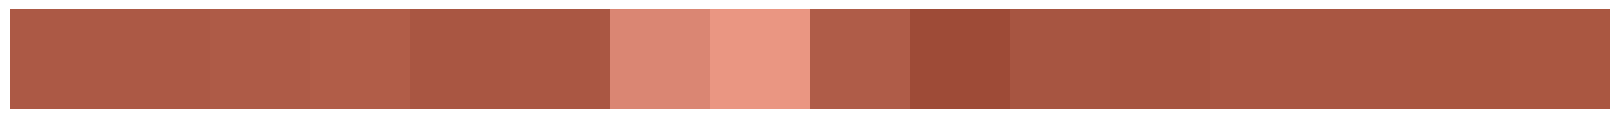

In [2029]:
Vis.show_lab(slice_candidate)

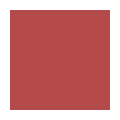

In [2030]:
Vis.show_rgb(top_rgb)

In [1966]:
idx_line = 5
yvals = np.array(d_xy_lines_v1[idx_line])[:, 0]
xvals = np.array([x_vlines[idx_line] for _ in range(len(yvals))])

In [1967]:
xvals

array([424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424, 424,
       424], dtype=int16)

In [1968]:
yvals

array([ 21,  29,  41,  50,  61,  72, 119, 127, 189, 250, 315, 363, 461,
       578])

Idx: 0   X:  64


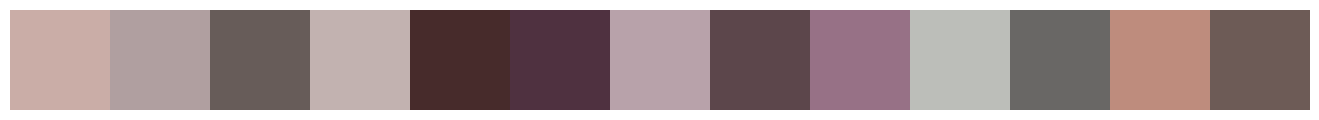

Idx: 1   X:  136


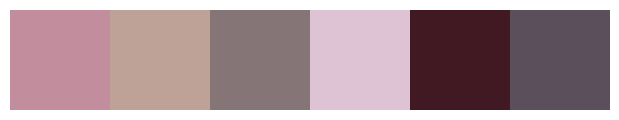

Idx: 2   X:  208


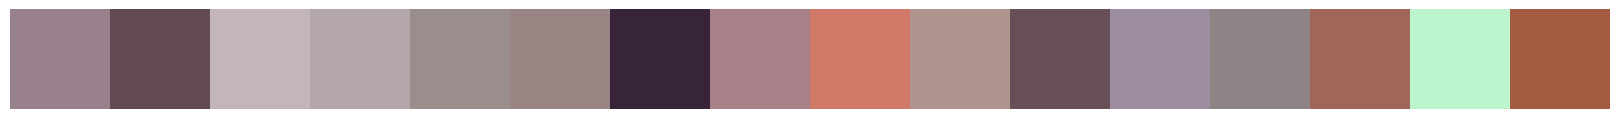

Idx: 3   X:  280


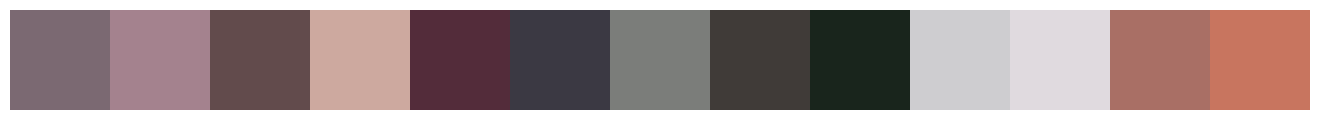

Idx: 4   X:  352


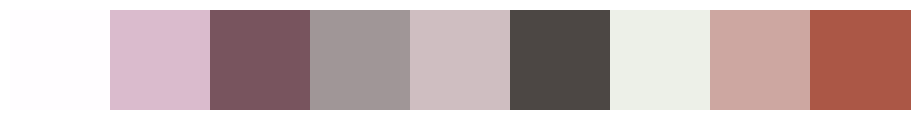

Idx: 5   X:  424


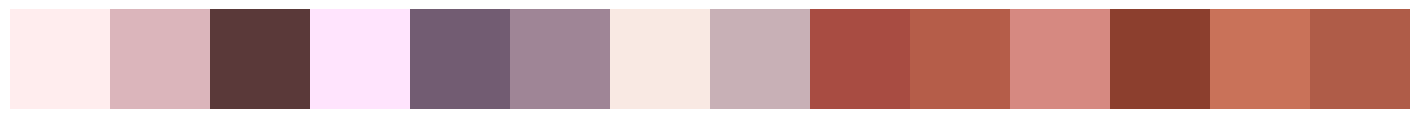

Idx: 6   X:  496


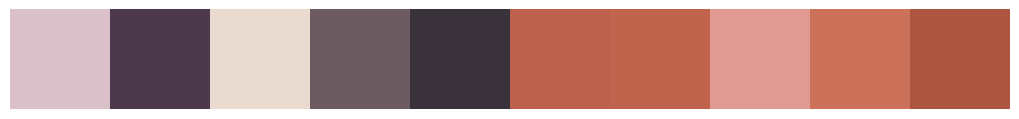

Idx: 7   X:  568


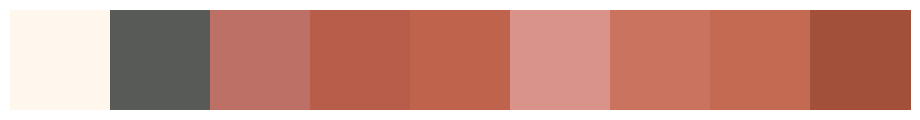

Idx: 8   X:  640


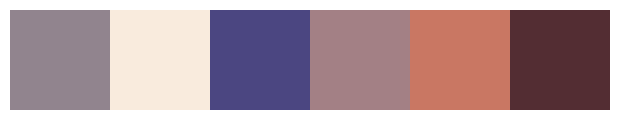

Idx: 9   X:  712


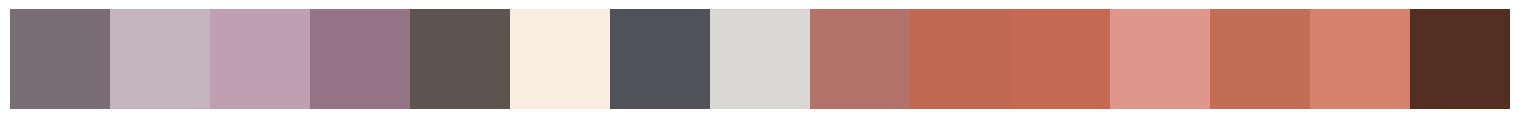

Idx: 10   X:  784


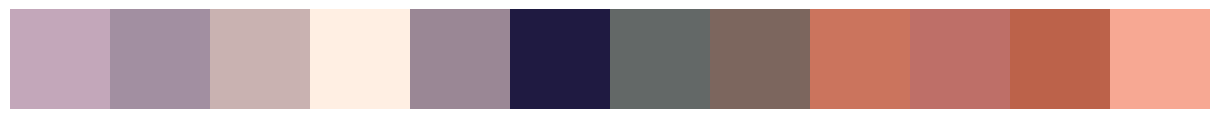

Idx: 11   X:  856


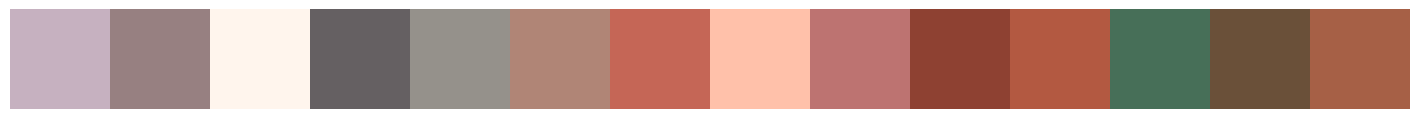

Idx: 12   X:  928


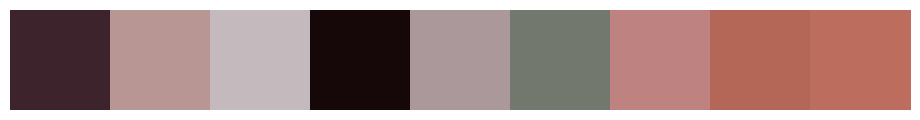

Idx: 13   X:  1000


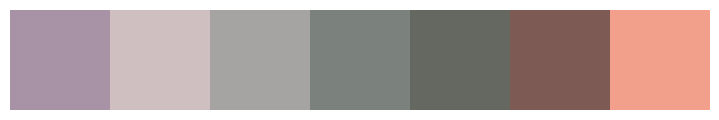

Idx: 14   X:  1072


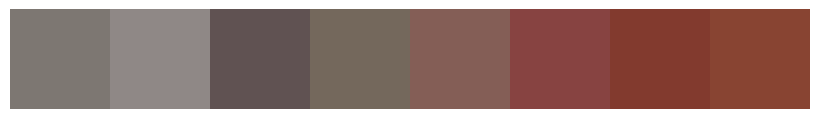

Idx: 15   X:  1144


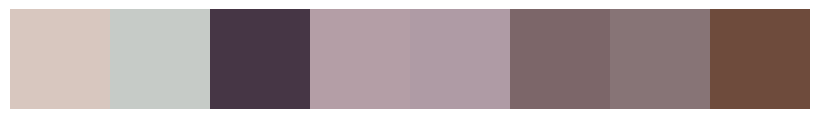

Idx: 16   X:  1216


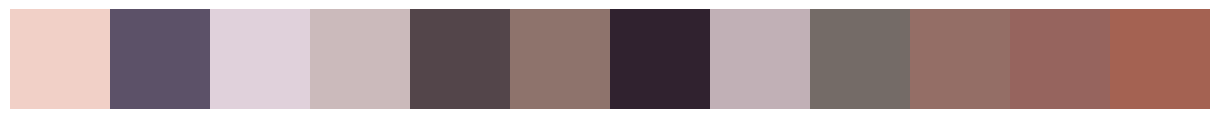

In [1962]:
# Take the first column being the Y values
for idx_line in range(len(x_vlines)):
    yvals = np.array(d_xy_lines_v1[idx_line])[:, 0]
    xvals = np.array([x_vlines[idx_line] for _ in range(len(yvals))])
    print("Idx:",idx_line, "  X: ", xvals[0])  
    Vis.show_rgb(frame[yvals,xvals,:])

### Visualize Strategy of grid

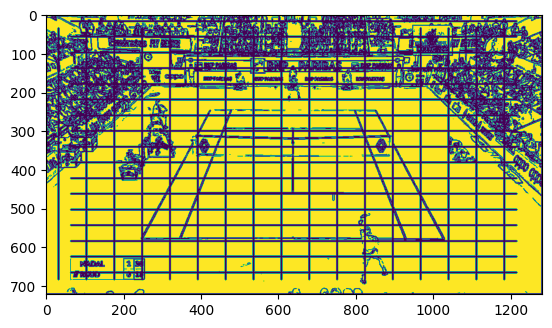

In [668]:
# Visualize strategy
mask_edges_grid = mask_edges.copy()
for xx in x_vlines:
    #cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
    pass
for yy in y_hlines:
    #cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
    pass
for xx in x_vlines_2:
    cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
    pass
for yy in y_hlines_2:
    cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
    pass
VC.show_frame(mask_edges_grid)

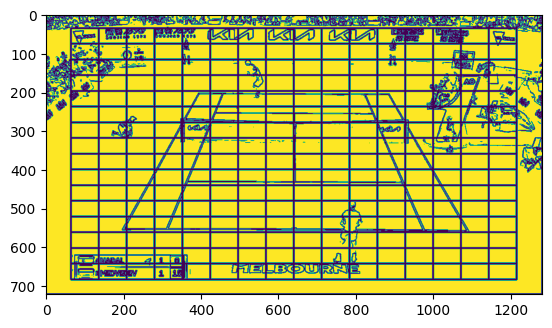

In [71]:
# Visualize strategy
mask_edges_grid = mask_edges.copy()
for xx in x_vlines:
    #cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
    pass
for yy in y_hlines:
    #cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
    pass
for xx in x_vlines_2:
    cv2.line(mask_edges_grid, (xx, min(y_hlines)), (xx, max(y_hlines)), (0, 255, 0), 3)
    pass
for yy in y_hlines_2:
    cv2.line(mask_edges_grid, (min(x_vlines), yy), (max(x_vlines), yy), (0, 0, 255), 3)
    pass
VC.show_frame(mask_edges_grid)

## Colors domination court

In [1854]:
ucol = reload(ucol)
uv = reload(uv)

Vis = uv.Visualizer()
Colors = ucol.Colors()

In [1817]:
tourn = "wb"

In [1818]:
%%time
frameg = d_fg[tourn].copy()
frame = d_f[tourn].copy()

CPU times: user 1.46 ms, sys: 390 µs, total: 1.85 ms
Wall time: 1.06 ms


In [1839]:
%%time
top_rgb, top_hex = Colors.run_top_colors_court(frame, top_k=4)

CPU times: user 84.5 ms, sys: 16.7 ms, total: 101 ms
Wall time: 100 ms


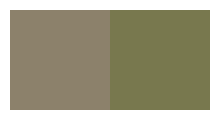

In [1841]:
Vis.show_rgb(top_rgb)

In [1855]:
xx = Colors.l_rgb2lab(top_rgb)

In [1856]:
xx

[(139, 128, 142), (126, 121, 151)]

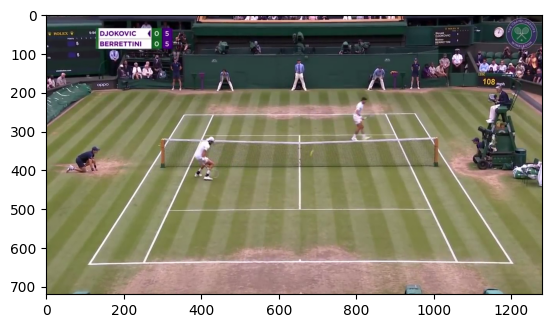

In [1827]:
VC.show_frame(frame)

## Lines in range of colors line colors of that court type

In [1842]:
frame_lab = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)

In [1843]:
frame_lab

array([[[ 12, 126, 128],
        [ 12, 126, 128],
        [ 12, 126, 128],
        ...,
        [ 16, 126, 132],
        [ 16, 126, 132],
        [ 16, 126, 132]],

       [[ 33, 124, 129],
        [ 32, 122, 129],
        [ 26, 123, 129],
        ...,
        [ 51, 125, 133],
        [ 54, 126, 133],
        [ 54, 126, 133]],

       [[ 42, 126, 126],
        [ 36, 126, 126],
        [ 21, 124, 127],
        ...,
        [ 50, 126, 133],
        [ 51, 125, 133],
        [ 51, 125, 133]],

       ...,

       [[144, 120, 152],
        [144, 120, 152],
        [143, 120, 153],
        ...,
        [146, 123, 148],
        [149, 123, 148],
        [149, 123, 148]],

       [[136, 119, 153],
        [137, 120, 153],
        [136, 119, 153],
        ...,
        [141, 123, 148],
        [142, 123, 148],
        [142, 123, 148]],

       [[133, 119, 153],
        [133, 119, 153],
        [133, 119, 153],
        ...,
        [133, 123, 149],
        [133, 123, 149],
        [132, 123, 149]]

## XXX

In [1588]:
hue_clay, sat_clay = rgb2hsv(c.RGB_LINE_GREENSET_AOd + tol)[0], rgb2hsv(c.RGB_LINE_GREENSET_AOd + tol)[1]
hue_lined, sat_lined = rgb2hsv(RGB_WHITE)[0], rgb2hsv(RGB_WHITE)[1]

NameError: name 'tol' is not defined

In [740]:
hue_clay, sat_clay

(0.5740740740740741, 0.4057377049180328)

In [741]:
hue_lined, sat_lined

(0.0, 0.0)

In [742]:
%%time
lower_mask = frame_hsv [:,:,0] > 1
upper_mask = frame_hsv [:,:,0] < hue_clay + 0.1
saturation = (frame_hsv [:,:,1] > 0)

CPU times: user 7.55 ms, sys: 1.14 ms, total: 8.69 ms
Wall time: 6.95 ms


In [743]:
%%time
mask = np.logical_and(np.logical_or(upper_mask, lower_mask), saturation)

CPU times: user 1.43 ms, sys: 845 µs, total: 2.27 ms
Wall time: 1.06 ms


In [744]:
%%time
mask = np.uint8(mask)
linewdith_blur = 10
kernel = np.ones((linewdith_blur,linewdith_blur),np.float32)/linewdith_blur**2
mask = cv2.filter2D(mask,-1,kernel)

CPU times: user 7.84 ms, sys: 1.35 ms, total: 9.19 ms
Wall time: 7.33 ms


In [745]:
%%time
red = frame[:,:,0]*mask
green = frame[:,:,1]*mask
blue = frame[:,:,2]*mask
frame_color_masked = np.dstack((red,green,blue))

CPU times: user 4.54 ms, sys: 699 µs, total: 5.24 ms
Wall time: 3.87 ms


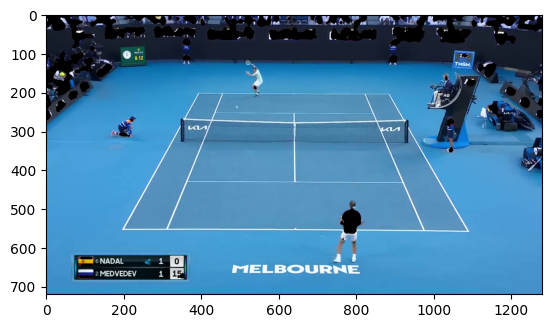

In [746]:
VC.show_frame(frame_color_masked)

In [634]:
arr = frame_hsv.reshape(-1, 3)

In [642]:
col1 = np.round(rgb2hsv(c.RGB_LINE_CLAYd + tol),4)
col2 = np.round(rgb2hsv(c.RGB_COURTS + tol),4)

array([0.0467, 0.3923, 0.    ], dtype=float16)

In [648]:
%%time
## mask of white line
mask_white_line = cv2.inRange(frame_hsv, np.float16(col1), np.float16(HSV_WHITE))

error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'inRange'
> Overload resolution failed:
>  - lowerb data type = 23 is not supported
>  - Expected Ptr<cv::UMat> for argument 'lowerb'


In [650]:
cv2.inRange?

Docstring:
inRange(src, lowerb, upperb[, dst]) -> dst
.   @brief  Checks if array elements lie between the elements of two other arrays.
.   
.   The function checks the range as follows:
.   -   For every element of a single-channel input array:
.       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0\f]
.   -   For two-channel arrays:
.       \f[\texttt{dst} (I)= \texttt{lowerb} (I)_0  \leq \texttt{src} (I)_0 \leq  \texttt{upperb} (I)_0  \land \texttt{lowerb} (I)_1  \leq \texttt{src} (I)_1 \leq  \texttt{upperb} (I)_1\f]
.   -   and so forth.
.   
.   That is, dst (I) is set to 255 (all 1 -bits) if src (I) is within the
.   specified 1D, 2D, 3D, ... box and 0 otherwise.
.   
.   When the lower and/or upper boundary parameters are scalars, the indexes
.   (I) at lowerb and upperb in the above formulas should be omitted.
.   @param src first input array.
.   @param lowerb inclusive lower boundary array or a scalar.
.   @param upperb inclusi

In [357]:
from collections import Counter

In [358]:
Counter(np.ravel(mask_white_line))

Counter({0: 921600})

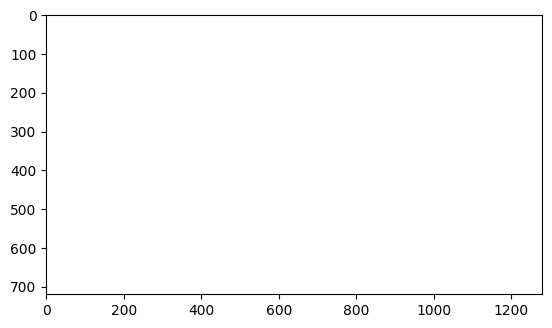

In [359]:
VC.show_gray(mask_white_line)

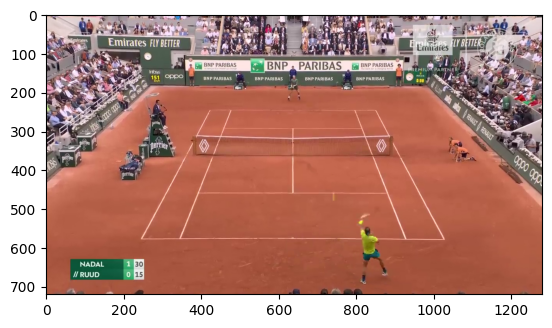

In [275]:
VC.show_frame(frame)

In [ ]:






## mask o yellow (15,0,0) ~ (36, 255, 255)
mask2 = cv2.inRange(hsv, (15,0,0), (36, 255, 255))

## final mask and masked
mask = cv2.bitwise_or(mask1, mask2)
target = cv2.bitwise_and(img,img, mask=mask)

cv2.imwrite("target.png", target)

In [ ]:
result = cv2.bitwise_and(nemo, nemo, mask=mask)
mask = cv2.inRange(hsv_nemo, light_orange, dark_orange)

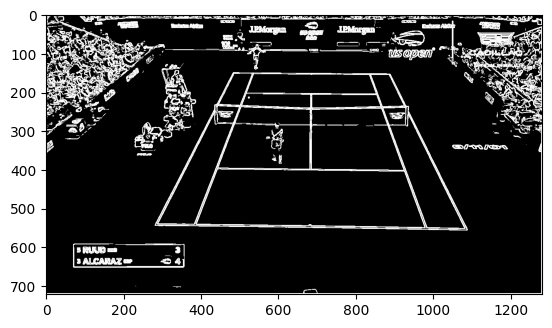

In [227]:
VC.show_gray(mask_edges*255)

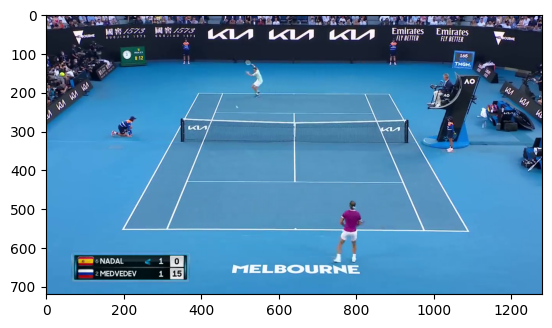

CPU times: user 352 ms, sys: 33.5 ms, total: 386 ms
Wall time: 292 ms


In [9]:
%%time
#mask_lines = VC.get_line_mask(frame, court_type)
#VC.show_gray(mask_lines)
#VC.show_gray(mask_lines[500:600,200:300])
VC.show_frame(frame)

In [11]:
%%time
grad = gradient_image.GradientImage()
frame_up, frame_down, frame_left, frame_right = grad.get_grads(frame)

hola
CPU times: user 19.5 ms, sys: 19.6 ms, total: 39.2 ms
Wall time: 37.6 ms


In [12]:
%%time
fdup, fddown, fddleft, fddright = grad.get_frame_directions_diff(frame)
mask_lines_bin = np.maximum(grad.shift_frame_down(fdup), grad.shift_frame_left(fddright))
mask_lines_bin2 = np.maximum(grad.shift_frame_up(fddown), grad.shift_frame_right(fddleft))
mask_both = grad.multiply_diffs(mask_lines_bin, mask_lines_bin2)

CPU times: user 112 ms, sys: 23.4 ms, total: 135 ms
Wall time: 134 ms


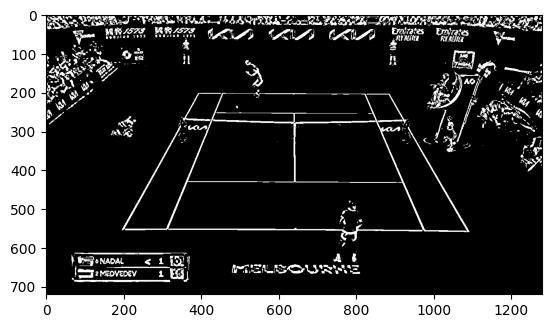

In [13]:
mask_final = grad.apply_threshold(mask_both, th=30)
VC.show_gray(mask_final*255)

In [160]:
val = 1
my_filter = np.array([
    [-val, 0, val],
    [-val, 0, val],
    [-val, 0, val],
])

In [172]:
%%time
vertical_edges = signal.correlate(frameg, my_filter, method="fft")
horizontal_edges = signal.correlate(frameg, my_filter.T, method="fft")

CPU times: user 61.7 ms, sys: 13.3 ms, total: 75.1 ms
Wall time: 72.8 ms


In [173]:
%%time
edges = np.sqrt(vertical_edges**2 + horizontal_edges**2)

CPU times: user 7.07 ms, sys: 2.27 ms, total: 9.33 ms
Wall time: 7.27 ms


In [174]:
%%time
edges_scaled = (255 / np.max(edges)) * edges

CPU times: user 2.62 ms, sys: 640 µs, total: 3.26 ms
Wall time: 2.16 ms


In [175]:
np.max(edges_scaled)

255.0

In [176]:
mask_edges = grad.apply_threshold(edges_scaled, th=50)


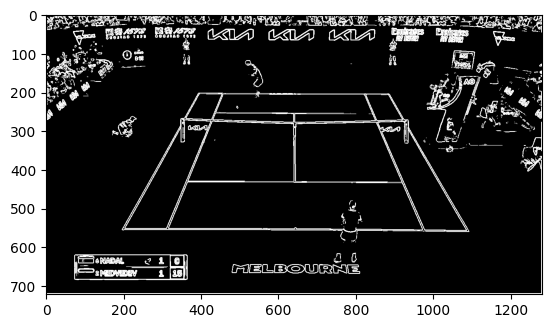

In [177]:
VC.show_gray(mask_edges*255)

## 3.3 Line Point detection

In [178]:
mask_final[426:436,544:545]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.]])

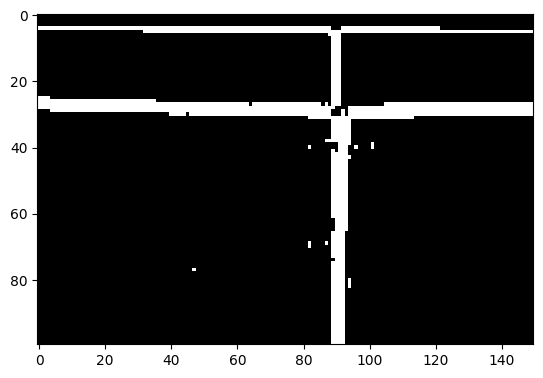

In [181]:
VC.show_gray(mask_final[250:350,550:700])

In [45]:
%%time
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_final*255), 50, 150)
# Detect points that form a line
lines = cv2.HoughLines(edges, 1, np.pi/180, 5)

CPU times: user 32.8 ms, sys: 2.92 ms, total: 35.7 ms
Wall time: 31.5 ms


In [48]:
for line in lines:
    break

In [49]:
line

array([[551.       ,   1.5707964]], dtype=float32)

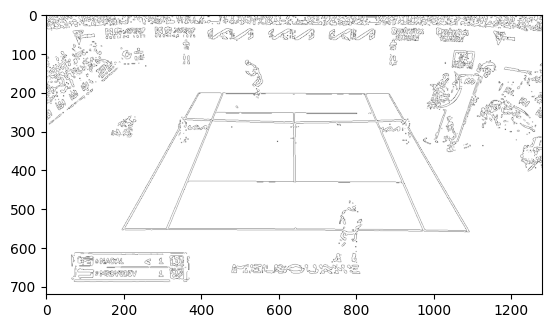

In [46]:
VC.show_gray(edges)

In [47]:
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_gray(framef)

ValueError: not enough values to unpack (expected 4, got 2)

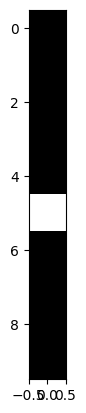

In [31]:
VC.show_gray(mask_final[426:436,544:545]*255)

In [372]:
gray = np.uint8(mask_final*255)
framef = frame.copy()

In [368]:
%%time
kernel_size = 5
blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
edges = cv2.Canny(mask_both,50,150,apertureSize = 3)

CPU times: user 10 ms, sys: 10.1 ms, total: 20.2 ms
Wall time: 9.74 ms


In [398]:
# https://scikit-image.org/docs/stable/auto_examples/edges/plot_line_hough_transform.html

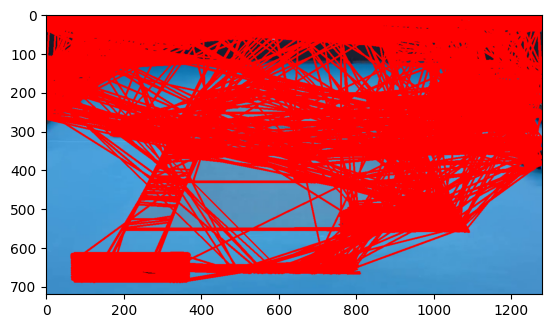

In [397]:
framef = frame.copy()
# Find the edges in the image using canny detector
edges = cv2.Canny(np.uint8(mask_both), 50, 150)
# Detect points that form a line
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 5, minLineLength=10, maxLineGap=250)
# Draw lines on the image
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(framef, (x1, y1), (x2, y2), (255, 0, 0), 3)
# Show result
VC.show_frame(framef)

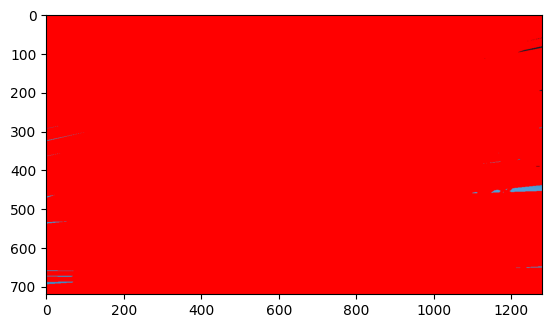

In [387]:
VC.show_frame(framef)

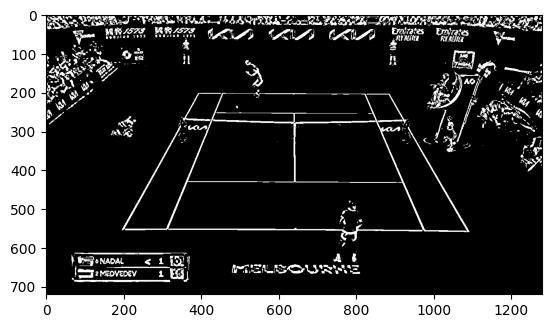

## Closest color

In [22]:
%%time
input_color = (100, 50, 25)
websafe_colors = [(200, 100, 50), (151,101,100)] # list of web-save colors
tree = sp.KDTree(websafe_colors) # creating k-d tree from web-save colors
ditsance, result = tree.query(input_color) # get Euclidean distance and index of web-save color in tree/list
nearest_color = websafe_colors[result]

CPU times: user 458 µs, sys: 162 µs, total: 620 µs
Wall time: 509 µs


In [23]:
ditsance

104.05287117614775

### Correct Slice

In [126]:
slif = frame[285:300, 505:506]
slim = mask_lines_bin[200:245, 400:655]

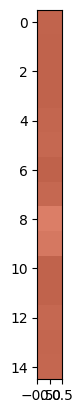

In [127]:
VC.show_frame(slif)

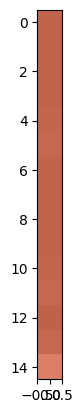

In [139]:
VC.show_frame(frame_down)

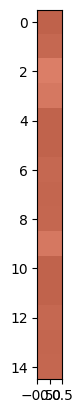

In [130]:
VC.show_frame(frame_up)

In [129]:
grad = GradientImage(slif)
frame_up, frame_down, frame_left, frame_right = grad.get_grads()

In [131]:
diff_up = slif - frame_up

In [138]:
diff_up

array([[[  2,   2,   2]],

       [[ -5,  -5,  -5]],

       [[-27, -27, -27]],

       [[-21, -21, -21]],

       [[  3,   3,   3]],

       [[  5,   5,   5]],

       [[ -6,  -6,  -6]],

       [[  2,   2,   2]],

       [[ 23,  23,  23]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]],

       [[  0,   0,   0]]])

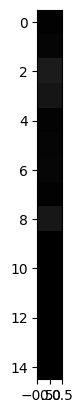

In [136]:
VC.show_frame(np.abs(diff_up))

In [307]:
sli.min(axis=1)

array([255., 255., 255., 255., 255., 255., 255., 255., 255., 255., 255.,
         0.,   0.,   0., 255., 255., 255., 255., 255., 255.])

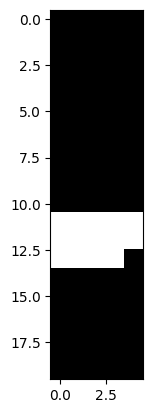

In [308]:
VC.show_gray(sli)

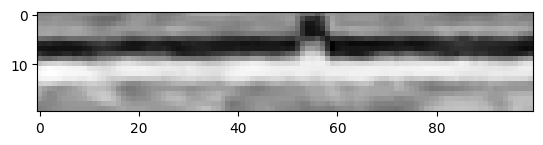

In [184]:
VC.show_gray(frame_diff_down[625:645, 600:700])

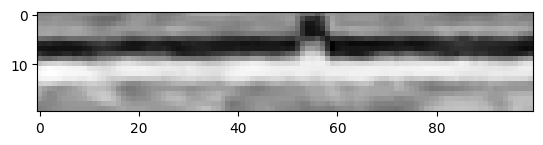

In [185]:
VC.show_gray(frame_diff_up[625:645, 600:700])

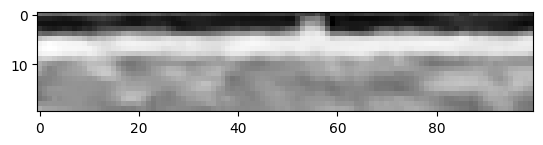

In [175]:
VC.show_gray(frame_diff_up_to_down[625:645, 600:700])

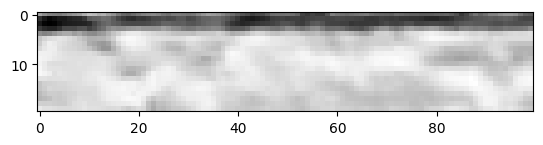

In [176]:
VC.show_gray(frame_diff_down_to_up[625:645, 600:700])                

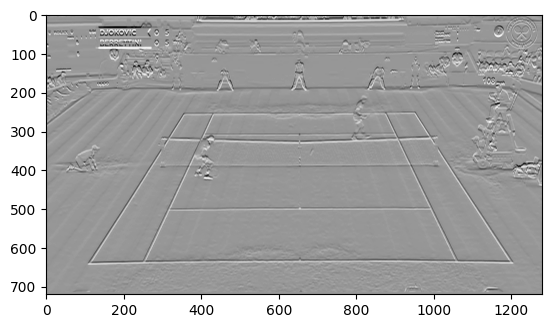

In [143]:
VC.show_gray(frame_diff_up)

In [106]:
np.max(frame_diff)

255.0

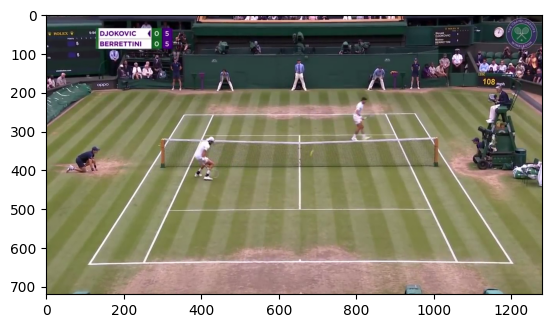

In [116]:
VC.show_frame(frame_down)